# **Treinamento**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import os
import warnings
import joblib
from tqdm.notebook import tqdm

# Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Algoritmos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Distribuições para RandomizedSearchCV
from scipy.stats import randint, uniform

# MLflow para rastreamento de experimentos
import mlflow

# Configurar avisos
warnings.filterwarnings('ignore')

In [2]:
# CONFIGURAÇÕES INICIAIS

# Configuração do MLflow
mlflow.set_tracking_uri("file:///home/willemromao/Downloads/TI/projetos_graduacao/ciencia_de_dados/cursos_graduacao_brasil/models/evaluation/mlruns")
experiment_name = "extincao_cursos_graduacao"
mlflow.set_experiment(experiment_name)

# Parâmetros globais para treinamento
N_ITER = 10    # Número de iterações para RandomizedSearchCV
CV_FOLDS = 3   # Número de folds para validação cruzada
N_JOBS = 6     # Número de cores para paralelismo

# Diretórios para salvar resultados
BASE_DIR = '/home/willemromao/Downloads/TI/projetos_graduacao/ciencia_de_dados/cursos_graduacao_brasil'
DATA_DIR = f"{BASE_DIR}/data"
MODEL_DIR = f"{BASE_DIR}/models/trained"
EVAL_DIR = f"{BASE_DIR}/models/evaluation"

# Criar diretórios se não existirem
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(EVAL_DIR, exist_ok=True)

In [3]:
# CARREGAMENTO E PREPARAÇÃO DE DADOS

df = pd.read_csv(f"{DATA_DIR}/preprocessed.csv")

print("Informações do dataset:")
df.info()

# Separação features e target
X = df.drop('EXTINTO', axis=1)
y = df['EXTINTO']

# Divisão conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

print(f"\nShape do conjunto de treino: {X_train.shape}")
print(f"Shape do conjunto de teste: {X_test.shape}")
print("\nDistribuição da variável alvo:")
print(f"Treino: {np.bincount(y_train.astype(int))}")
print(f"Teste: {np.bincount(y_test.astype(int))}")
print(f"Proporção de extinção: {np.sum(y)/len(y):.4f}")

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89492 entries, 0 to 89491
Data columns (total 21 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   GRAU_Licenciatura                                                          89492 non-null  float64
 1   GRAU_Sequencial                                                            89492 non-null  float64
 2   GRAU_Tecnológico                                                           89492 non-null  float64
 3   GRAU_Área Básica de Ingresso (ABI)                                         89492 non-null  float64
 4   MODALIDADE_Educação a Distância                                            89492 non-null  float64
 5   CATEGORIA_ADMINISTRATIVA_Privada com fins lucrativos                       89492 non-null  float64
 6   CATEGORIA_ADMINISTRATIVA_Priva

In [4]:
# FUNÇÕES AUXILIARES

def avaliar_modelo(y_true, y_pred, y_proba=None):
    """Calcula métricas de avaliação para um modelo de classificação"""
    metricas = {}
    metricas['acuracia'] = accuracy_score(y_true, y_pred)
    metricas['precisao'] = precision_score(y_true, y_pred)
    metricas['recall'] = recall_score(y_true, y_pred)
    metricas['f1'] = f1_score(y_true, y_pred)
    if y_proba is not None:
        metricas['auc'] = roc_auc_score(y_true, y_proba)
    return metricas

def plotar_matriz_confusao(y_true, y_pred, titulo="Matriz de Confusão"):
    """Plota a matriz de confusão"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(titulo)
    plt.ylabel('Real')
    plt.xlabel('Predito')
    return plt.gcf()

def plotar_curva_roc(y_true, y_proba, titulo="Curva ROC"):
    """Plota a curva ROC"""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title(titulo)
    plt.legend(loc="lower right")
    return plt.gcf()

def treinar_modelo(nome, config, X_train, y_train, X_test, y_test, n_iter=N_ITER, cv_folds=CV_FOLDS, n_jobs=N_JOBS):
    """Treina um modelo com busca de hiperparâmetros e avalia seu desempenho"""
    start_time = time.time()
    
    resultado = {}
    
    # Iniciar uma execução no MLflow
    with mlflow.start_run(run_name=nome) as run:
        # Registrar parâmetros básicos
        mlflow.log_param("modelo", nome)
        mlflow.log_param("n_iter", n_iter)
        mlflow.log_param("cv_folds", cv_folds)
        
        # Criar pipeline de modelagem
        pipeline = Pipeline([('modelo', config['modelo'])])
        
        # Configurar validação cruzada estratificada
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        # Configurar e executar RandomizedSearchCV
        random_search = RandomizedSearchCV(
            pipeline,
            param_distributions=config['params'],
            n_iter=n_iter,
            cv=cv,
            scoring='roc_auc',
            n_jobs=n_jobs,
            verbose=1,
            random_state=42,
            return_train_score=True
        )
        
        # Treinar o modelo
        random_search.fit(X_train, y_train)
        
        # Registrar os melhores hiperparâmetros
        best_params = random_search.best_params_
        for param, value in best_params.items():
            clean_param = param.replace('modelo__', '')
            mlflow.log_param(clean_param, value)
        
        # Obter o melhor modelo
        best_model = random_search.best_estimator_
        
        # Fazer predições no conjunto de teste
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Avaliar o modelo
        metricas = avaliar_modelo(y_test, y_pred, y_proba)
        
        # Registrar métricas no MLflow
        for metrica, valor in metricas.items():
            mlflow.log_metric(metrica, valor)
        
        # Validação cruzada no conjunto de treino
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')
        mlflow.log_metric("cv_auc_mean", cv_scores.mean())
        mlflow.log_metric("cv_auc_std", cv_scores.std())
        
        # Calcular tempo de execução
        end_time = time.time()
        exec_time = end_time - start_time
        mlflow.log_metric("execution_time", exec_time)
        
        # Gerar e salvar visualizações
        fig_cm = plotar_matriz_confusao(y_test, y_pred, titulo=f"Matriz de Confusão - {nome}")
        mlflow.log_figure(fig_cm, f"matriz_confusao_{nome.lower().replace(' ', '_')}.png")
        plt.close()
        
        fig_roc = plotar_curva_roc(y_test, y_proba, titulo=f"Curva ROC - {nome}")
        mlflow.log_figure(fig_roc, f"curva_roc_{nome.lower().replace(' ', '_')}.png")
        plt.close()
        
        # Relatório de classificação
        class_report = classification_report(y_test, y_pred)
        mlflow.log_text(class_report, f"report_{nome.lower().replace(' ', '_')}.txt")
        
        # Registrar o modelo no MLflow
        input_example = X_train.iloc[:1]
        mlflow.sklearn.log_model(
            best_model, 
            name=f"modelo_{nome.lower().replace(' ', '_')}", 
            input_example=input_example
        )
        
        # Armazenar resultados
        resultado = {
            'modelo': best_model,
            'params': best_params,
            'metricas': metricas,
            'cv_scores': cv_scores,
            'tempo_exec': exec_time,
            'mlflow_run_id': run.info.run_id,
            'fig_cm': fig_cm,
            'fig_roc': fig_roc
        }
        
        # Mostrar resultados
        print(f"\nResultados para {nome}:")
        print(f"  AUC: {metricas['auc']:.4f}")
        print(f"  F1: {metricas['f1']:.4f}")
        print(f"  Precisão: {metricas['precisao']:.4f}")
        print(f"  Recall: {metricas['recall']:.4f}")
        print(f"  AUC médio (CV): {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        print(f"  Tempo: {exec_time:.2f} segundos")
        
    return resultado

In [5]:
# DEFINIÇÃO DE MODELOS E HIPERPARÂMETROS

modelos = {
    'Decision Tree': {
        'modelo': DecisionTreeClassifier(random_state=1),
        'params': {
            'modelo__max_depth': [3, 5],  
            'modelo__min_samples_split': randint(2, 3),
            'modelo__min_samples_leaf': [1],
            'modelo__criterion': ['gini']  
        }
    },
    'KNN': {
        'modelo': KNeighborsClassifier(),
        'params': {
            'modelo__n_neighbors': [3, 5],  
            'modelo__weights': ['uniform'],  
            'modelo__algorithm': ['kd_tree'],  
            'modelo__p': [2]  
        }
    },
    'Naive Bayes': {
        'modelo': GaussianNB(),
        'params': {}  
    },
    'MLP': {
        'modelo': MLPClassifier(max_iter=100, random_state=1),  
        'params': {
            'modelo__hidden_layer_sizes': [(50,)],  
            'modelo__activation': ['relu'],  
            'modelo__alpha': [0.0001, 0.001],  
            'modelo__learning_rate': ['constant']  
        }
    },
    'Logistic Regression': {
        'modelo': LogisticRegression(max_iter=200, random_state=1),  
        'params': {
            'modelo__C': [0.1, 1.0],  
            'modelo__solver': ['liblinear'],  
            'modelo__penalty': ['l2']  
        }
    },
    'SVM': {
        'modelo': SVC(probability=True, random_state=1, C=1.0, kernel='linear', gamma='scale'),
        'params': {}
    },
    'Random Forest': {
        'modelo': RandomForestClassifier(random_state=1),
        'params': {
            'modelo__n_estimators': [50],  
            'modelo__max_depth': [5, 10],  
            'modelo__min_samples_split': [2],  
            'modelo__min_samples_leaf': [1]  
        }
    },
    'XGBoost': {
        'modelo': XGBClassifier(eval_metric='logloss', random_state=1),
        'params': {
            'modelo__n_estimators': [50], 
            'modelo__max_depth': [3],  
            'modelo__learning_rate': [0.05, 0.1],  
            'modelo__subsample': [0.8],  
            'modelo__colsample_bytree': [0.8],  
            'modelo__gamma': [0]  
        }
    }
}

# Criar dicionário para armazenar resultados
resultados = {}

Iniciando treinamento do Decision Tree...


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Resultados para Decision Tree:
  AUC: 0.8889
  F1: 0.8172
  Precisão: 0.8531
  Recall: 0.7841
  AUC médio (CV): 0.8870 (±0.0009)
  Tempo: 2.69 segundos


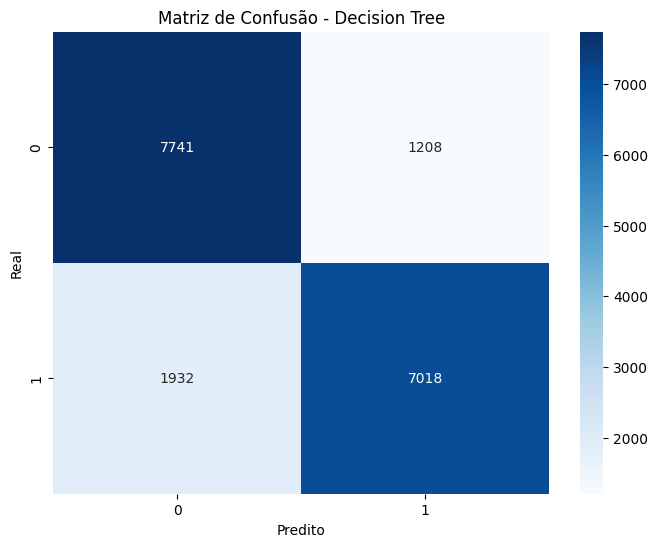

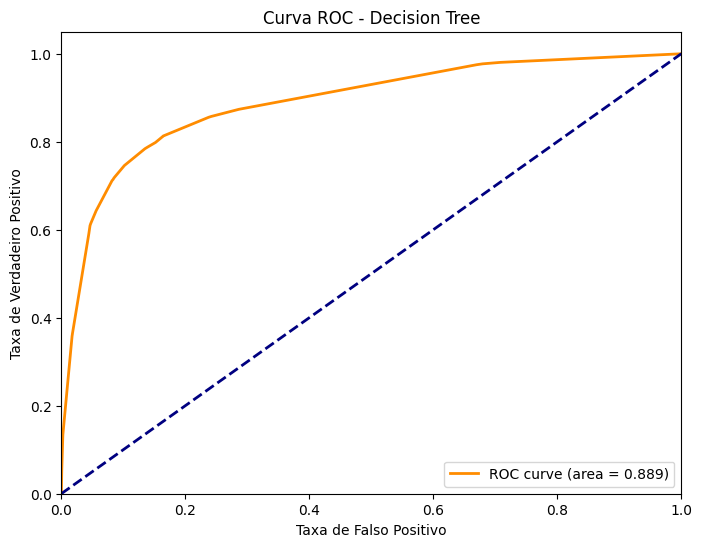

Treinamento do Decision Tree concluído!


In [6]:
# TREINAMENTO - Decision Tree

from IPython.display import display

print("Iniciando treinamento do Decision Tree...")
with tqdm(total=100) as pbar:
    pbar.set_description("Decision Tree")
    pbar.update(10)  
    
    resultados['Decision Tree'] = treinar_modelo(
        'Decision Tree', 
        modelos['Decision Tree'],
        X_train, y_train,
        X_test, y_test
    )
    
    pbar.update(90)
    
display(resultados['Decision Tree']['fig_cm'])
display(resultados['Decision Tree']['fig_roc'])
print("Treinamento do Decision Tree concluído!")

Iniciando treinamento do KNN...


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Resultados para KNN:
  AUC: 0.8834
  F1: 0.8363
  Precisão: 0.8102
  Recall: 0.8640
  AUC médio (CV): 0.8908 (±0.0014)
  Tempo: 60.74 segundos


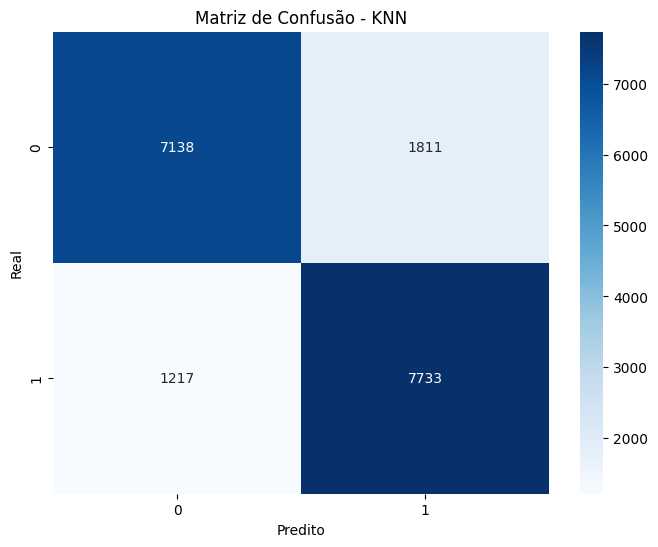

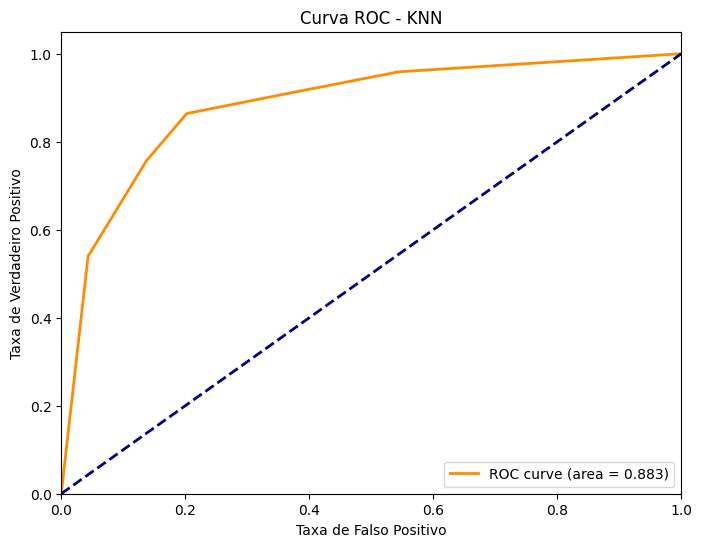

Treinamento do KNN concluído!


In [7]:
# TREINAMENTO - KNN

print("Iniciando treinamento do KNN...")
with tqdm(total=100) as pbar:
    pbar.set_description("KNN")
    pbar.update(10)
    
    resultados['KNN'] = treinar_modelo(
        'KNN', 
        modelos['KNN'],
        X_train, y_train,
        X_test, y_test
    )
    
    pbar.update(90)

display(resultados['KNN']['fig_cm'])
display(resultados['KNN']['fig_roc'])
print("Treinamento do KNN concluído!")

Iniciando treinamento do Naive Bayes...


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Resultados para Naive Bayes:
  AUC: 0.8480
  F1: 0.7062
  Precisão: 0.8839
  Recall: 0.5879
  AUC médio (CV): 0.8474 (±0.0011)
  Tempo: 0.46 segundos


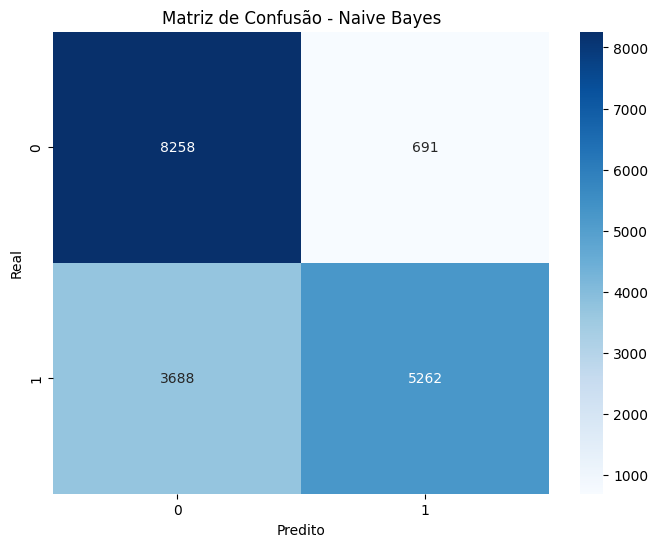

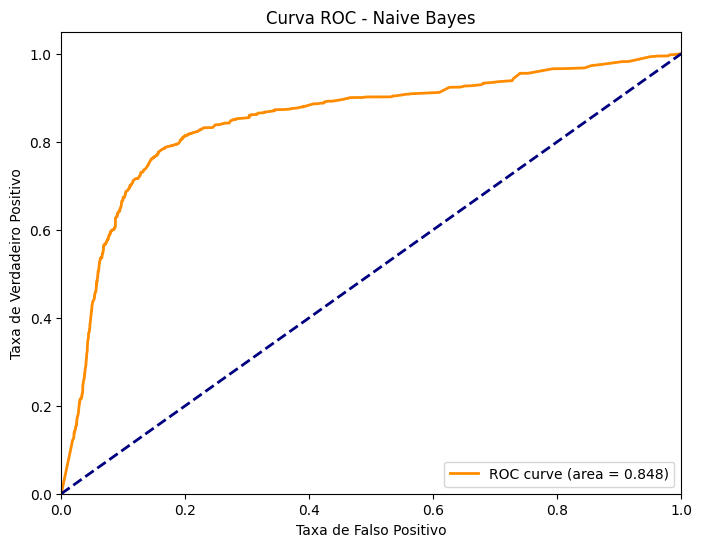

Treinamento do Naive Bayes concluído!


In [8]:
# TREINAMENTO - Naive Bayes

print("Iniciando treinamento do Naive Bayes...")
with tqdm(total=100) as pbar:
    pbar.set_description("Naive Bayes")
    pbar.update(10)
    
    resultados['Naive Bayes'] = treinar_modelo(
        'Naive Bayes', 
        modelos['Naive Bayes'],
        X_train, y_train,
        X_test, y_test
    )
    
    pbar.update(90)

display(resultados['Naive Bayes']['fig_cm'])
display(resultados['Naive Bayes']['fig_roc'])
print("Treinamento do Naive Bayes concluído!")

Iniciando treinamento do MLP...


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/willemromao/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/willemromao/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/willemromao/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/willemromao/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/willem


Resultados para MLP:
  AUC: 0.9164
  F1: 0.8446
  Precisão: 0.8633
  Recall: 0.8267
  AUC médio (CV): 0.9135 (±0.0009)
  Tempo: 51.76 segundos


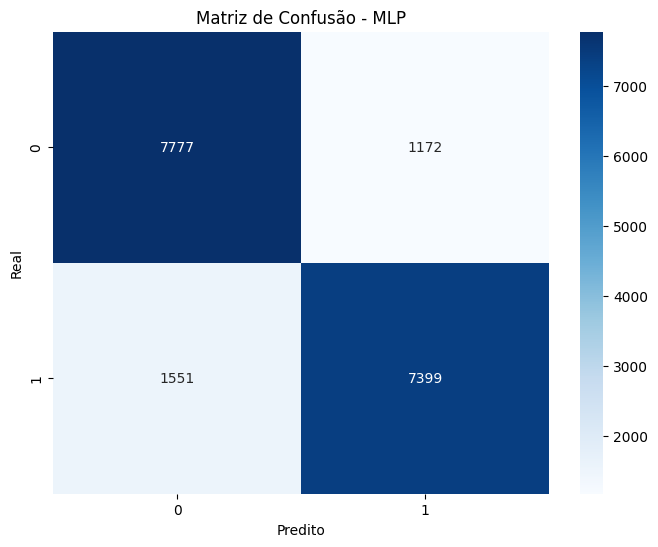

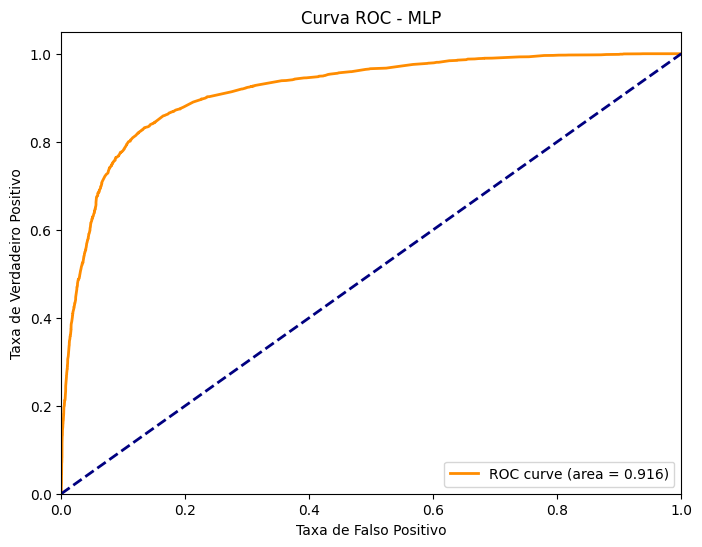

Treinamento do MLP concluído!


In [9]:
# TREINAMENTO - MLP

print("Iniciando treinamento do MLP...")
with tqdm(total=100) as pbar:
    pbar.set_description("MLP")
    pbar.update(10)
    
    resultados['MLP'] = treinar_modelo(
        'MLP', 
        modelos['MLP'],
        X_train, y_train,
        X_test, y_test
    )
    
    pbar.update(90)

display(resultados['MLP']['fig_cm'])
display(resultados['MLP']['fig_roc'])
print("Treinamento do MLP concluído!")

Iniciando treinamento da Regressão Logística...


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Resultados para Logistic Regression:
  AUC: 0.8813
  F1: 0.7973
  Precisão: 0.8395
  Recall: 0.7592
  AUC médio (CV): 0.8803 (±0.0014)
  Tempo: 1.51 segundos


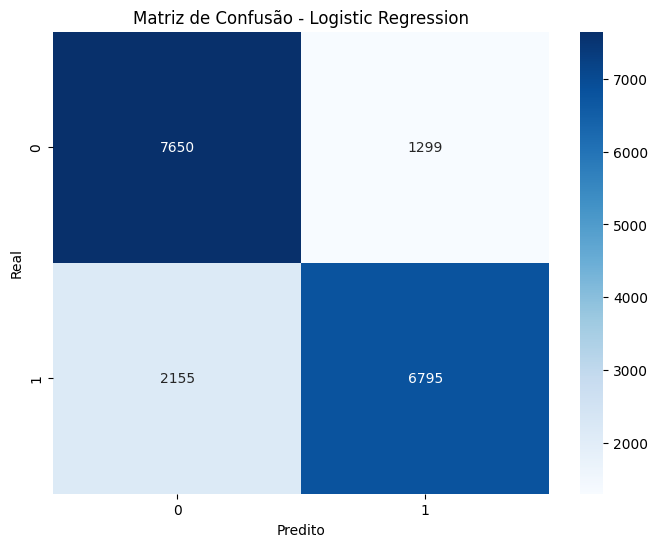

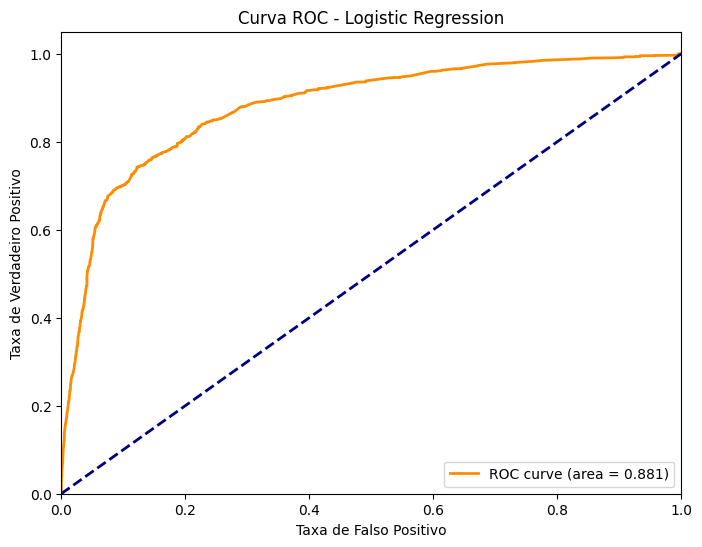

Treinamento da Regressão Logística concluído!


In [10]:
# TREINAMENTO - Logistic Regression

print("Iniciando treinamento da Regressão Logística...")
with tqdm(total=100) as pbar:
    pbar.set_description("Logistic Regression")
    pbar.update(10)
    
    resultados['Logistic Regression'] = treinar_modelo(
        'Logistic Regression', 
        modelos['Logistic Regression'],
        X_train, y_train,
        X_test, y_test
    )
    
    pbar.update(90)

display(resultados['Logistic Regression']['fig_cm'])
display(resultados['Logistic Regression']['fig_roc'])
print("Treinamento da Regressão Logística concluído!")

Iniciando treinamento do SVM...


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Resultados para SVM:
  AUC: 0.8655
  F1: 0.8129
  Precisão: 0.8231
  Recall: 0.8029
  AUC médio (CV): 0.8677 (±0.0008)
  Tempo: 2041.09 segundos


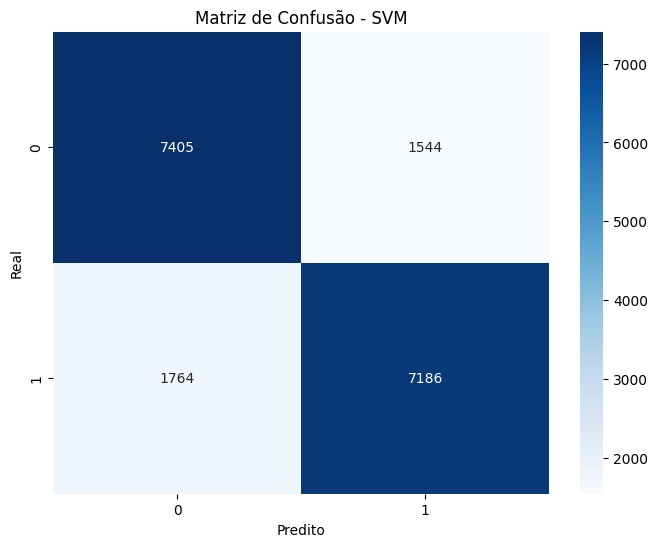

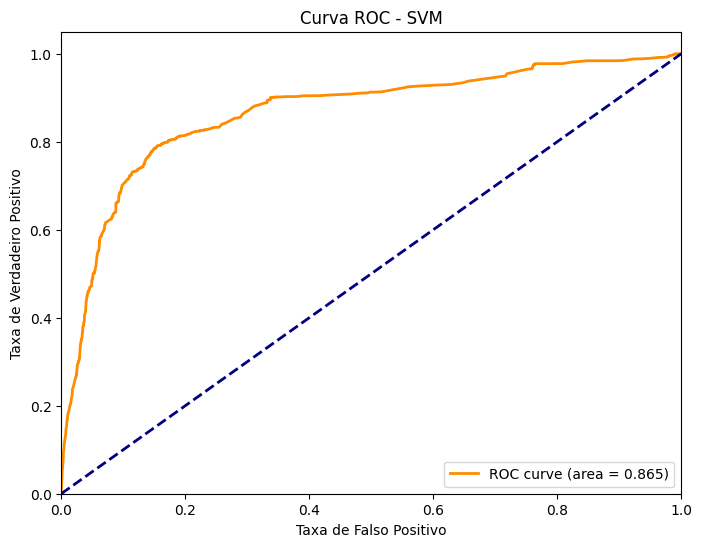

Treinamento do SVM concluído!


In [11]:
# TREINAMENTO - SVM

print("Iniciando treinamento do SVM...")
with tqdm(total=100) as pbar:
    pbar.set_description("SVM")
    pbar.update(10)
    
    resultados['SVM'] = treinar_modelo(
        'SVM', 
        modelos['SVM'],
        X_train, y_train,
        X_test, y_test
    )
    
    pbar.update(90)

display(resultados['SVM']['fig_cm'])
display(resultados['SVM']['fig_roc'])
print("Treinamento do SVM concluído!")

Iniciando treinamento do Random Forest...


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Resultados para Random Forest:
  AUC: 0.9197
  F1: 0.8461
  Precisão: 0.8659
  Recall: 0.8273
  AUC médio (CV): 0.9169 (±0.0010)
  Tempo: 7.48 segundos


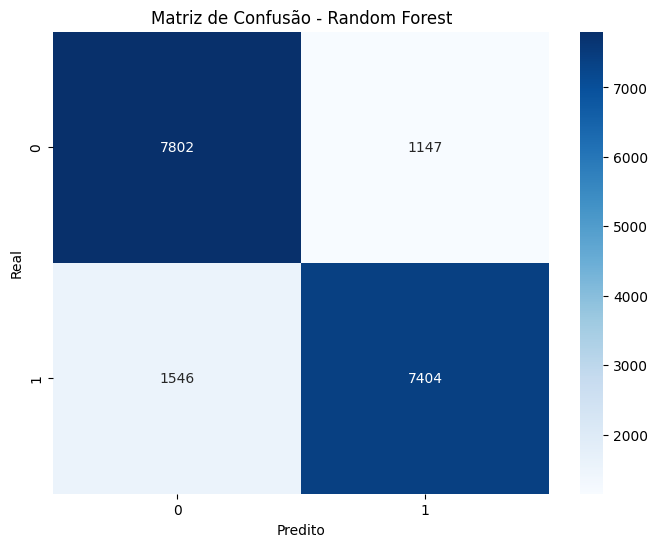

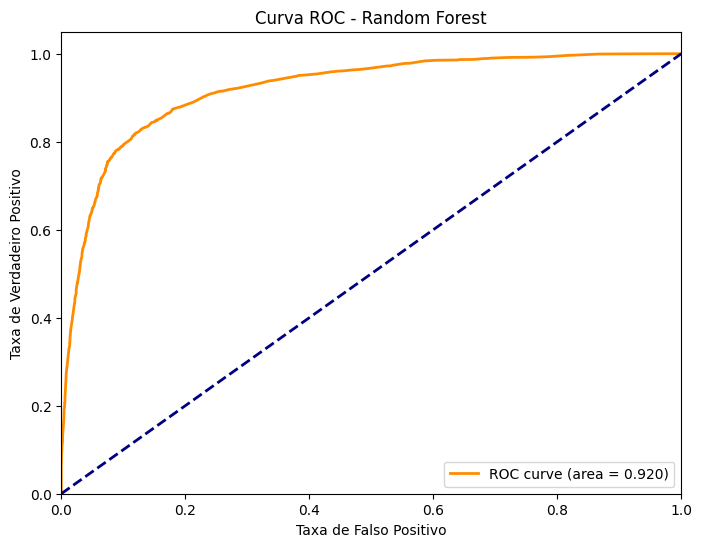

Treinamento do Random Forest concluído!


In [12]:
# TREINAMENTO - Random Forest

print("Iniciando treinamento do Random Forest...")
with tqdm(total=100) as pbar:
    pbar.set_description("Random Forest")
    pbar.update(10)
    
    resultados['Random Forest'] = treinar_modelo(
        'Random Forest', 
        modelos['Random Forest'],
        X_train, y_train,
        X_test, y_test
    )
    
    pbar.update(90)

display(resultados['Random Forest']['fig_cm'])
display(resultados['Random Forest']['fig_roc'])
print("Treinamento do Random Forest concluído!")

Iniciando treinamento do XGBoost...


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Resultados para XGBoost:
  AUC: 0.8994
  F1: 0.8209
  Precisão: 0.8434
  Recall: 0.7996
  AUC médio (CV): 0.8982 (±0.0015)
  Tempo: 1.37 segundos


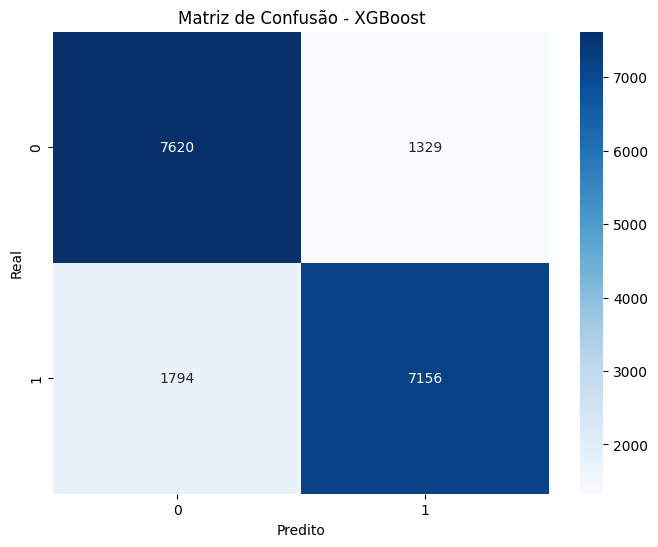

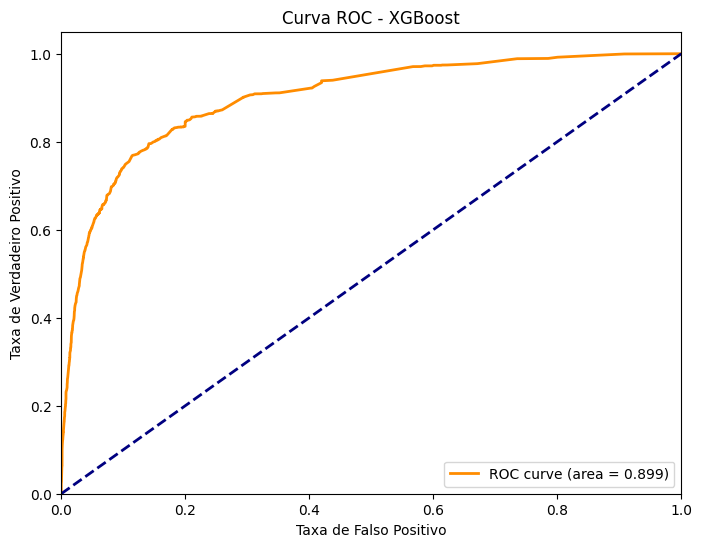

Treinamento do XGBoost concluído!


In [13]:
# TREINAMENTO - XGBoost

print("Iniciando treinamento do XGBoost...")
with tqdm(total=100) as pbar:
    pbar.set_description("XGBoost")
    pbar.update(10)
    
    resultados['XGBoost'] = treinar_modelo(
        'XGBoost', 
        modelos['XGBoost'],
        X_train, y_train,
        X_test, y_test
    )
    
    pbar.update(90)

display(resultados['XGBoost']['fig_cm'])
display(resultados['XGBoost']['fig_roc'])
print("Treinamento do XGBoost concluído!")


===== COMPARAÇÃO DOS MODELOS =====


,Accuracy,Precision,Recall,F1,AUC,CV AUC,Time (s)
Random Forest,0.849545,0.865864,0.827263,0.846123,0.919653,0.916918,7.477529
MLP,0.847869,0.863260,0.826704,0.844586,0.916353,0.913495,51.755635
XGBoost,0.825521,0.843371,0.799553,0.820878,0.899356,0.898182,1.369468
Decision Tree,0.824571,0.853149,0.784134,0.817187,0.888861,0.886973,2.692434
KNN,0.830829,0.810247,0.864022,0.836271,0.883408,0.890769,60.744705
Logistic Regression,0.807028,0.839511,0.759218,0.797348,0.881345,0.880294,1.513759
SVM,0.815185,0.823139,0.802905,0.812896,0.865494,0.867680,2041.093085
Naive Bayes,0.755349,0.883924,0.587933,0.706167,0.848013,0.847413,0.456252


<Figure size 1200x800 with 0 Axes>

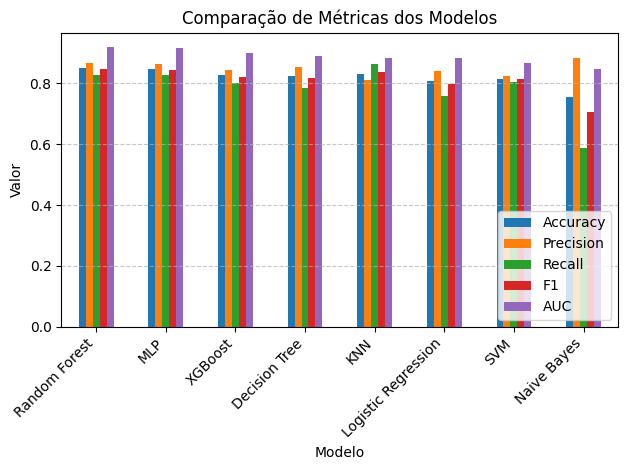

In [23]:
# COMPARAÇÃO DE MODELOS

# Criar DataFrame com os resultados para comparação
resultados_df = pd.DataFrame({
    nome: {
        'Accuracy': info['metricas']['acuracia'],
        'Precision': info['metricas']['precisao'],
        'Recall': info['metricas']['recall'],
        'F1': info['metricas']['f1'],
        'AUC': info['metricas']['auc'],
        'CV AUC': info['cv_scores'].mean(),
        'Time (s)': info['tempo_exec']
    }
    for nome, info in resultados.items()
}).T

# Ordenar por AUC (da maior para a menor)
resultados_df = resultados_df.sort_values('AUC', ascending=False)

print("\n===== COMPARAÇÃO DOS MODELOS =====")
display(resultados_df)

plt.figure(figsize=(12, 8))
ax = resultados_df[['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']].plot(kind='bar')
plt.title('Comparação de Métricas dos Modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'{EVAL_DIR}/comparison_models.png')
plt.show()

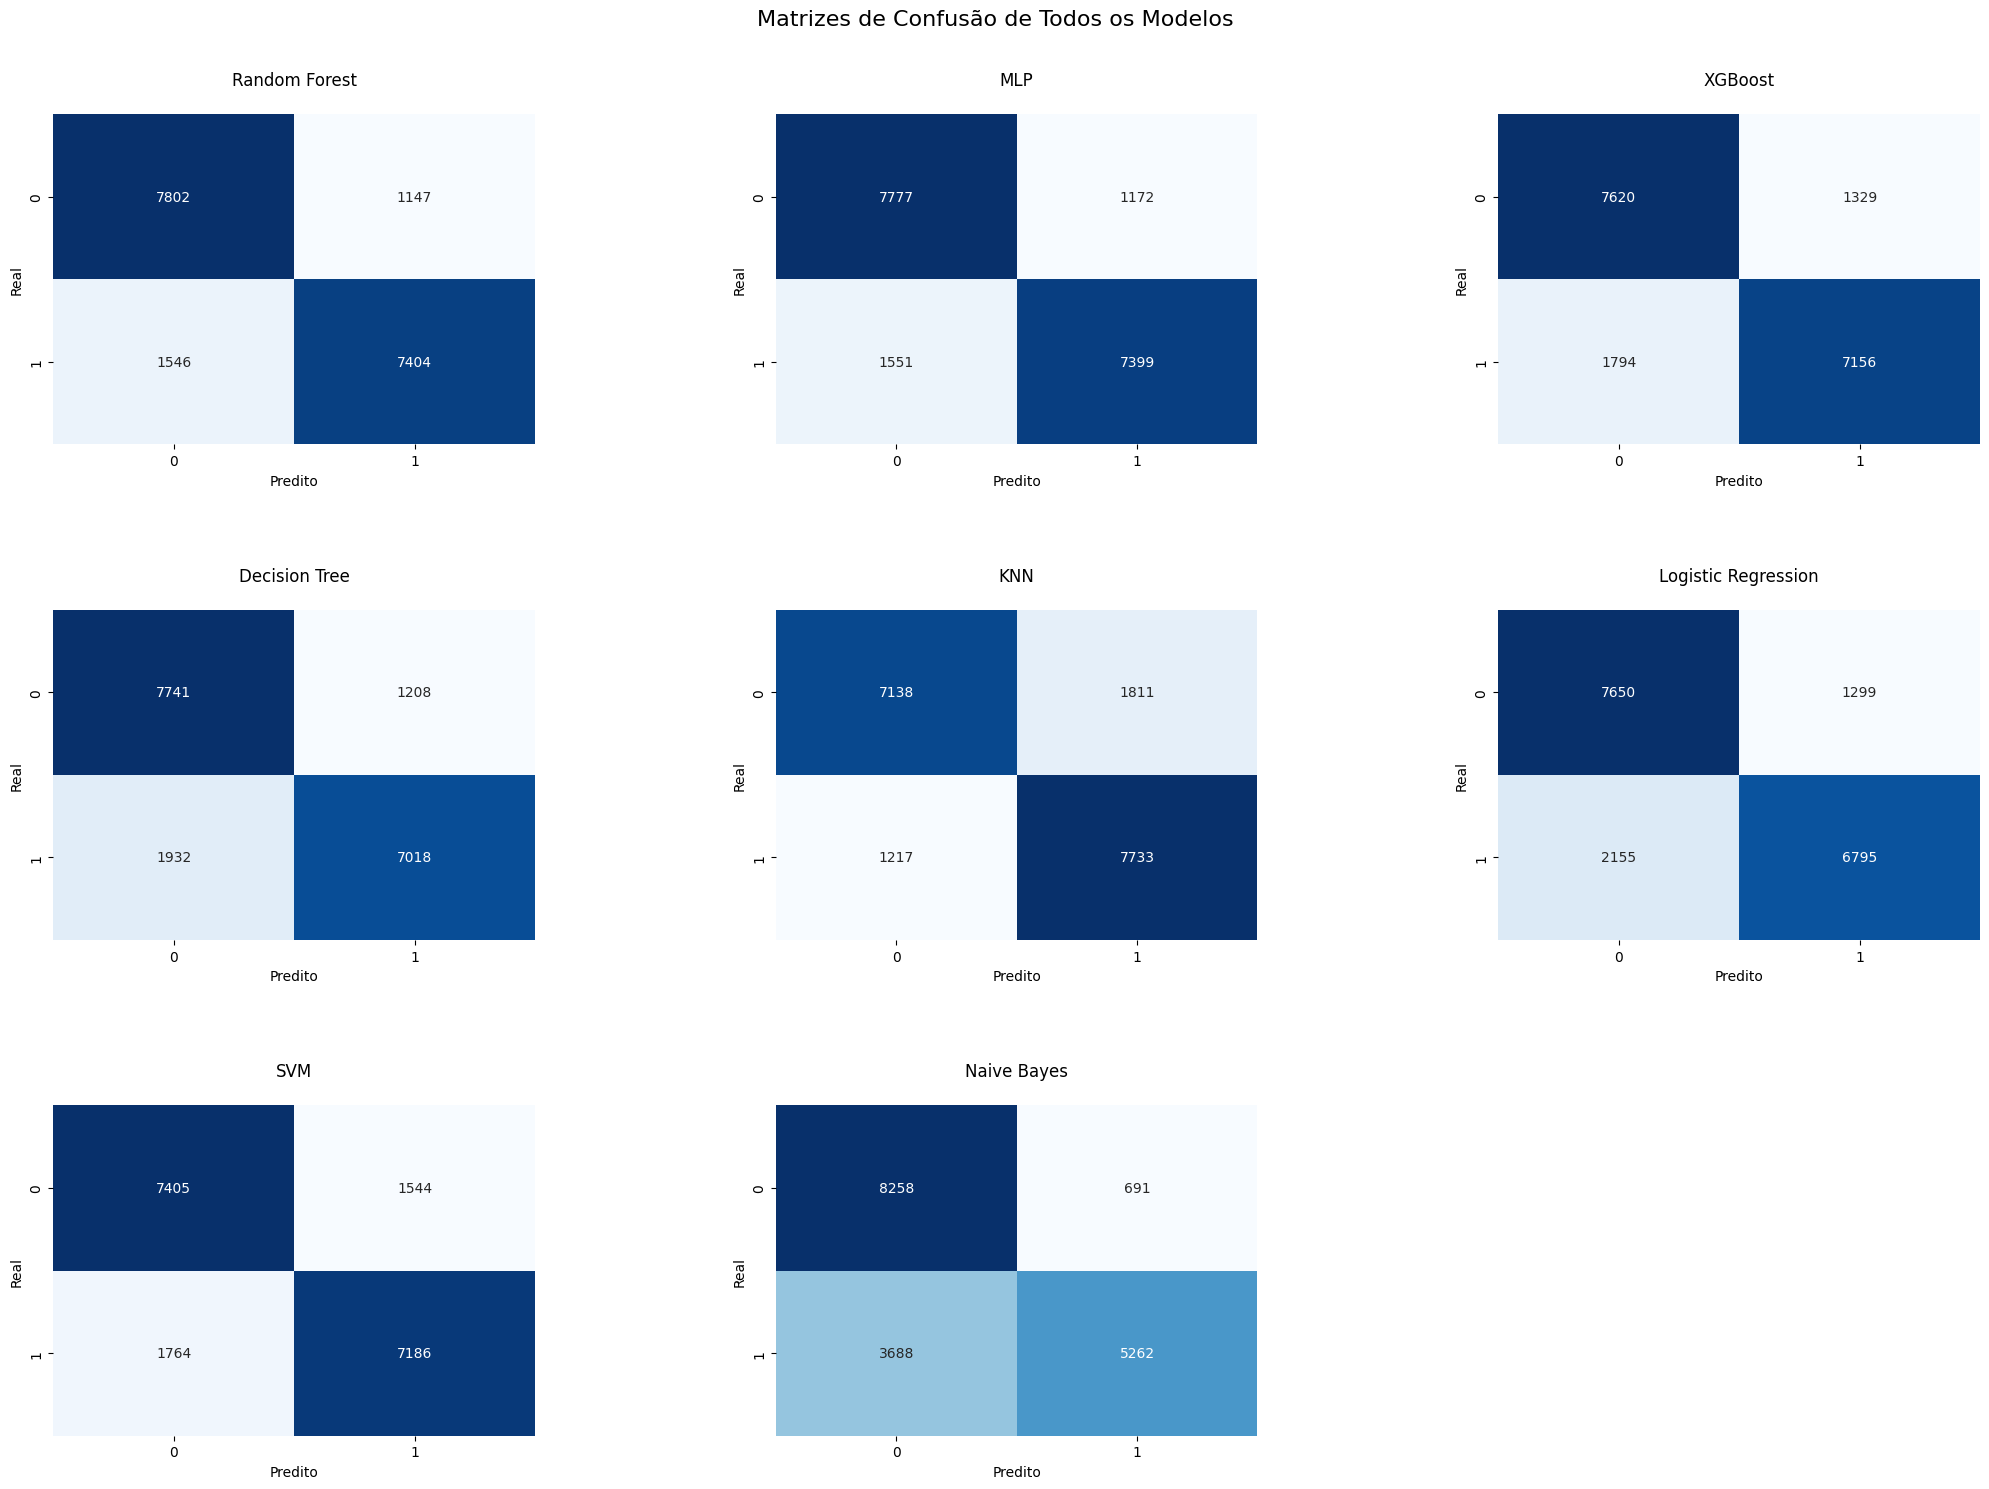

In [21]:
# VISUALIZAÇÃO DE TODAS AS MATRIZES DE CONFUSÃO

# Determinar número de linhas e colunas para o layout de subplots
n_models = len(resultados)
n_cols = 3  # Podemos usar 3 colunas
n_rows = (n_models + n_cols - 1) // n_cols  # Calcula quantas linhas são necessárias

# Criar figura e subplots
plt.figure(figsize=(20, 5*n_rows))
plt.suptitle('Matrizes de Confusão de Todos os Modelos', fontsize=16, y=0.99)

# Ordenar modelos pelo desempenho (AUC)
modelos_ordenados = resultados_df.index

for i, modelo_nome in enumerate(modelos_ordenados):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Obter a matriz de confusão do modelo
    y_pred = resultados[modelo_nome]['modelo'].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotar a matriz de confusão
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    # Adicionar rótulos e título
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title(f"{modelo_nome}\n", fontsize=12)
    
    # Garantir que os eixos estão visíveis
    plt.tight_layout()

# Ajustar o layout e salvar
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.92)
plt.savefig(f'{EVAL_DIR}/all_confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

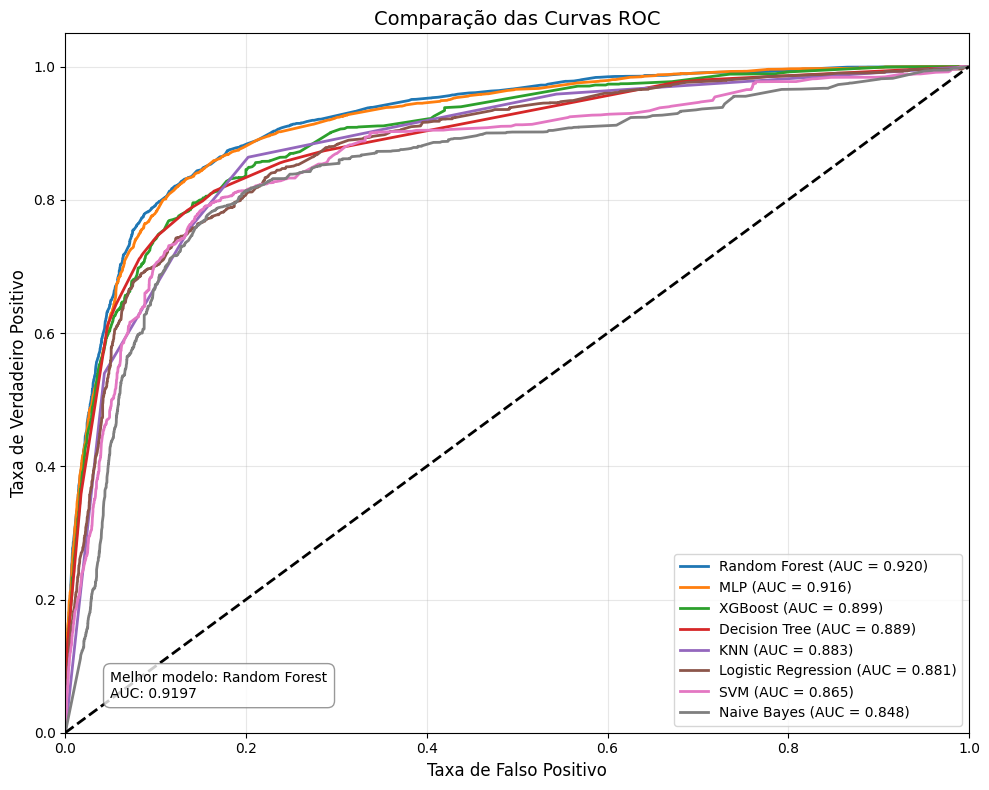

<Figure size 640x480 with 0 Axes>

In [16]:
# VISUALIZAÇÃO DE TODAS AS CURVAS ROC

plt.figure(figsize=(10, 8))

# Ordenar modelos pelo desempenho (AUC)
modelos_ordenados = resultados_df.index

# Definir cores diferentes para cada modelo
colors = plt.cm.tab10.colors  

# Plotar a curva ROC para cada modelo
for i, modelo_nome in enumerate(modelos_ordenados):
    # Calcular curva ROC
    y_proba = resultados[modelo_nome]['modelo'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = resultados[modelo_nome]['metricas']['auc']
    
    # Plotar curva ROC com cor específica
    plt.plot(
        fpr, 
        tpr, 
        lw=2, 
        color=colors[i % len(colors)],
        label=f'{modelo_nome} (AUC = {roc_auc:.3f})'
    )

# Plotar linha diagonal de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo', fontsize=12)
plt.ylabel('Taxa de Verdadeiro Positivo', fontsize=12)
plt.title('Comparação das Curvas ROC', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Adicionar texto com informações sobre o melhor modelo
best_model = resultados_df.index[0]
best_auc = resultados_df['AUC'].max()
plt.annotate(
    f'Melhor modelo: {best_model}\nAUC: {best_auc:.4f}', 
    xy=(0.05, 0.05), 
    xycoords='axes fraction',
    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8)
)

# Salvar o gráfico
plt.tight_layout()
plt.savefig(f'{EVAL_DIR}/all_roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Registrar no MLflow
with mlflow.start_run(run_name="model_comparison"):
    mlflow.log_figure(plt.gcf(), "all_roc_curves_comparison.png")

In [21]:
# IDENTIFICAÇÃO E SALVAMENTO DO MELHOR MODELO

# Identificar o melhor modelo
melhor_modelo_nome = resultados_df.index[0]
melhor_modelo_info = resultados[melhor_modelo_nome]

print(f"\n===== MELHOR MODELO =====")
print(f"Modelo: {melhor_modelo_nome}")
print(f"AUC: {melhor_modelo_info['metricas']['auc']:.4f}")
print(f"F1: {melhor_modelo_info['metricas']['f1']:.4f}")
print(f"Precisão: {melhor_modelo_info['metricas']['precisao']:.4f}")
print(f"Recall: {melhor_modelo_info['metricas']['recall']:.4f}")

# Salvar o melhor modelo
modelo_path = f"{MODEL_DIR}/best_model_{melhor_modelo_nome.lower().replace(' ', '_')}.joblib"
joblib.dump(melhor_modelo_info['modelo'], modelo_path)
print(f"\nMelhor modelo salvo em: {modelo_path}")

# Salvar informações do modelo em um arquivo de texto
info_path = f"{MODEL_DIR}/info_model_{melhor_modelo_nome.lower().replace(' ', '_')}.txt"
with open(info_path, 'w') as f:
    f.write(f"===== INFORMAÇÕES DO MODELO =====\n")
    f.write(f"Modelo: {melhor_modelo_nome}\n")
    f.write(f"Data de treinamento: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("Métricas de desempenho:\n")
    for metrica, valor in melhor_modelo_info['metricas'].items():
        f.write(f"  {metrica}: {valor:.4f}\n")
    
    f.write(f"\nCV AUC: {melhor_modelo_info['cv_scores'].mean():.4f} (±{melhor_modelo_info['cv_scores'].std():.4f})\n")
    f.write(f"Tempo de execução: {melhor_modelo_info['tempo_exec']:.2f} segundos\n\n")
    
    f.write("Melhores hiperparâmetros:\n")
    for param, valor in melhor_modelo_info['params'].items():
        f.write(f"  {param}: {valor}\n")
        
    f.write(f"\nRun ID MLflow: {melhor_modelo_info['mlflow_run_id']}\n")
    
    # Adicionar informação sobre a distribuição das classes
    f.write(f"\nDistribuição das classes:\n")
    f.write(f"  Classe 0 (Não Extinto): {np.bincount(y.astype(int))[0]}\n")
    f.write(f"  Classe 1 (Extinto): {np.bincount(y.astype(int))[1]}\n")
    f.write(f"  Proporção de extinção: {np.bincount(y.astype(int))[1] / len(y):.4f}\n")

print(f"Informações do modelo salvas em: {info_path}")


===== MELHOR MODELO =====
Modelo: Random Forest
AUC: 0.9197
F1: 0.8461
Precisão: 0.8659
Recall: 0.8273

Melhor modelo salvo em: /home/willemromao/Downloads/TI/projetos_graduacao/ciencia_de_dados/cursos_graduacao_brasil/models/trained/best_model_random_forest.joblib
Informações do modelo salvas em: /home/willemromao/Downloads/TI/projetos_graduacao/ciencia_de_dados/cursos_graduacao_brasil/models/trained/info_model_random_forest.txt


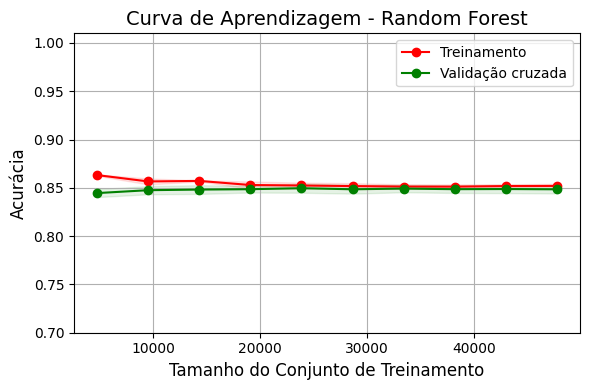

<Figure size 640x480 with 0 Axes>

In [23]:
# GRÁFICO DE CURVA DE APRENDIZAGEM DO MELHOR MODELO

# Obter o melhor modelo identificado anteriormente
melhor_modelo = melhor_modelo_info['modelo']

# Configurar tamanhos de amostra para a curva de aprendizagem
train_sizes = np.linspace(0.1, 1.0, 10)

# Calcular curvas de aprendizagem
train_sizes, train_scores, test_scores = learning_curve(
    melhor_modelo, 
    X_train, 
    y_train,
    train_sizes=train_sizes,
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=N_JOBS
)

# Calcular médias e desvios padrão
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotar curvas de aprendizagem
plt.figure(figsize=(6, 4))
plt.grid()

plt.fill_between(
    train_sizes, 
    train_mean - train_std,
    train_mean + train_std, 
    alpha=0.1, 
    color="r"
)
plt.fill_between(
    train_sizes, 
    test_mean - test_std,
    test_mean + test_std, 
    alpha=0.1, 
    color="g"
)
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Treinamento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validação cruzada")

plt.title(f"Curva de Aprendizagem - {melhor_modelo_nome}", fontsize=14)
plt.xlabel("Tamanho do Conjunto de Treinamento", fontsize=12)
plt.ylabel("Acurácia", fontsize=12)
plt.ylim(0.7, 1.01)
plt.legend(loc="best")

# Salvar e exibir o gráfico
plt.savefig(f'{EVAL_DIR}/learning_curve_{melhor_modelo_nome.lower().replace(" ", "_")}.png', dpi=300)
plt.tight_layout()
plt.show()

# Registrar no MLflow
with mlflow.start_run(run_id=melhor_modelo_info['mlflow_run_id']):
    mlflow.log_figure(plt.gcf(), "learning_curve.png")

In [20]:
# SALVAR MODELO NO FORMATO MLFLOW

try:
    mlflow_model_path = f"{MODEL_DIR}/mlflow_model_{melhor_modelo_nome.lower().replace(' ', '_')}"
    if not os.path.exists(mlflow_model_path):
        os.makedirs(mlflow_model_path)
    
    with mlflow.start_run(run_id=melhor_modelo_info['mlflow_run_id']) as run:
        mlflow.sklearn.save_model(
            melhor_modelo_info['modelo'],
            mlflow_model_path,
            input_example=X.iloc[:1]
        )
    
    print(f"Modelo MLflow salvo em: {mlflow_model_path}")
except Exception as e:
    print(f"Erro ao salvar o modelo em formato MLflow: {e}")

Modelo MLflow salvo em: /home/willemromao/Downloads/TI/projetos_graduacao/ciencia_de_dados/cursos_graduacao_brasil/models/trained/mlflow_model_random_forest


In [24]:
# INICIAR INTERFACE MLFLOW

print("Iniciando interface do MLflow...")
print("Acesse: http://localhost:5000")
!mlflow ui --backend-store-uri {EVAL_DIR}/mlruns

Iniciando interface do MLflow...
Acesse: http://localhost:5000
[2025-07-11 00:19:51 -0300] [15046] [INFO] Starting gunicorn 23.0.0
[2025-07-11 00:19:51 -0300] [15046] [INFO] Listening at: http://127.0.0.1:5000 (15046)
[2025-07-11 00:19:51 -0300] [15046] [INFO] Using worker: sync
[2025-07-11 00:19:51 -0300] [15047] [INFO] Booting worker with pid: 15047
[2025-07-11 00:19:51 -0300] [15048] [INFO] Booting worker with pid: 15048
[2025-07-11 00:19:51 -0300] [15049] [INFO] Booting worker with pid: 15049
[2025-07-11 00:19:51 -0300] [15050] [INFO] Booting worker with pid: 15050
2025/07/11 00:24:24 ERROR mlflow.server: Exception on /ajax-api/2.0/mlflow/model-versions/delete [DELETE]
Traceback (most recent call last):
  File "/home/willemromao/miniconda3/lib/python3.12/site-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/willemromao/miniconda3/lib/python3.12/site-packages/flask/app.py", line 919, 